In [230]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "/root/Documents/PLDAC/dataset"

In [231]:
#pour rendre le notebook plus clean!
def printMatrice(sim, series):
    plt.figure(figsize=(10,10))
    plt.imshow(sim, cmap='YlGn', interpolation='nearest')
    plt.xticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
    plt.yticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series])
    plt.show()
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    mdr = [(series[i], a) for i, a in enumerate(sim[series.index(serie)])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k]]:
        print("  ", " ".join(b))

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **44 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

In [232]:
series_df = pd.read_csv("series.csv")
series_df = series_df.dropna(subset=["genres"])
series = list(series_df["seriesname"])
series_df[["seriesname", "genres"]].head(3)

,seriesname,genres
0,2318_Raising_the_Bar,Drama
1,1159_Rejseholdet_(Unit_One),Drama
2,1821_Til_Death,Comedy


calculons la matrice de similarité de 1000 séries, puis évaluons les performances:

In [210]:
corpus = []
for serie in series_df["seriesname"]:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)
print(len(corpus))

939


In [211]:
"""

    BOW
    
    
"""

counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [219]:
"""

    TF-IDF
    
    
"""
customstopwords = stopwords.words('english') + ["yes","hmm","nah","oh","uh",
                                                "ye","na","ca","ok","got","come","back","up"]

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=3, max_features=2000, stop_words=customstopwords)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

sim = cosine_similarity(vec)

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [233]:
"""

    EMBEDDINGS
    

"""

sim = np.load("similarity_matrices/sim_13_.npy")


In [245]:
nbSeries = 3000
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]

In [235]:
#classe implémentant les mesures de rappel/précision/score F1
from utils.evalIRmodel import EvalIRmodel

Construisons la liste des séries pertinentes en terme de similarité pour chaque série: Commencons par les séries du même genre:

In [213]:
""" 
    PERTINENT BONNE VERSION 
    
    PAS TOUCHE
"""

everything = series_df[["seriesname","genres"]].values
from difflib import SequenceMatcher

ms = []
pertinents = []
skippable = []
forbidden = ['ction','Anim','ster','tion']
for c , one in enumerate(everything):
    string1 = one[1]
    tmp = []
    for two in everything:
        string2 = two[1]
        nom = two[0]
        match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
        mots = string1[match.a: match.a + match.size].split("-")
        yes = False
        for m in mots:
            if ((len(m)<4) or (m in forbidden)):
                continue
            yes = True
            break
        if yes:
            tmp.append(nom)
    if len(tmp) == 0:
        skippable.append(c)
        continue
    pertinents.append(tmp)

len(pertinents)

939

Et maintenant, passons à l'évalutation:

In [221]:
""" version normale """

similaires = []
for j , nom in enumerate(everything[:,0]):
    if j in skippable:
        continue
    ch = nom
    s = series.index(ch)
    if j != s:
        print("wooow")
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    l = []
    for a, b in mdr:
        df = series_df[series_df["seriesname"]==a]
        if df.empty:
            continue
        l.append(a)
    if len(l) == 0:
        print("WOOW")
    similaires.append(l)

len(similaires)

939

In [274]:
nbSeries = 3000
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]

In [281]:
""" version matrice de 3000 """

similaires = []
assez = True
count = 0
for j , nom in enumerate(everything[:,0]):
    if j in skippable:
        continue
    ch = nom

    s = series.index(ch)
    
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:350]
    l = []
    for a, b in mdr:
        df = series_df[series_df["seriesname"]==a]
        if df.empty:
            continue
        l.append(a)
    if len(l) == 0:
        print("WOOW")
    if len(l) < 50:
        count+=1
        assez = False
    similaires.append(l)

print(assez)
print(count)
len(similaires)

False
4


939

In [283]:
len(simTFIDF)
len(simEmbeddings)

939

In [284]:

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinents, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.868
rappel: 0.030
F1: 0.037


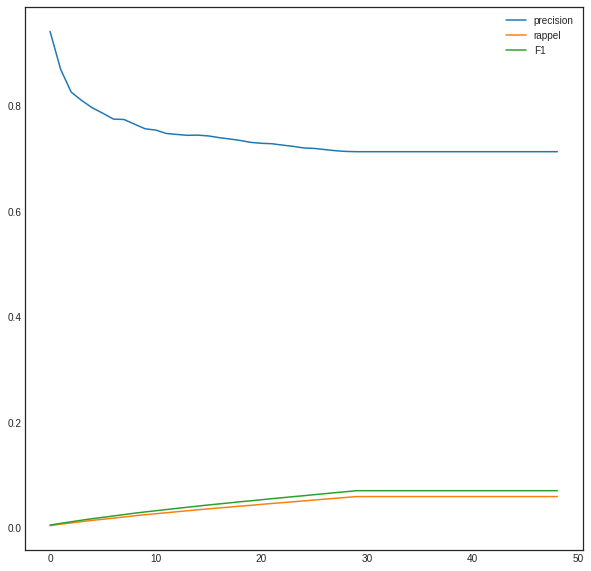

In [216]:
""" BOW """
ps = []
rs = []
fs = []

for i in range(1,50):
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(similaires, pertinents, k=i)

    ps.append(evaluations["precision"]["mean"])
    rs.append(evaluations["recall"]["mean"])
    fs.append(evaluations["F1"]["mean"])
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(ps, label="precision")
plt.plot(rs, label="rappel")
plt.plot(fs, label="F1")
plt.legend()
plt.show()

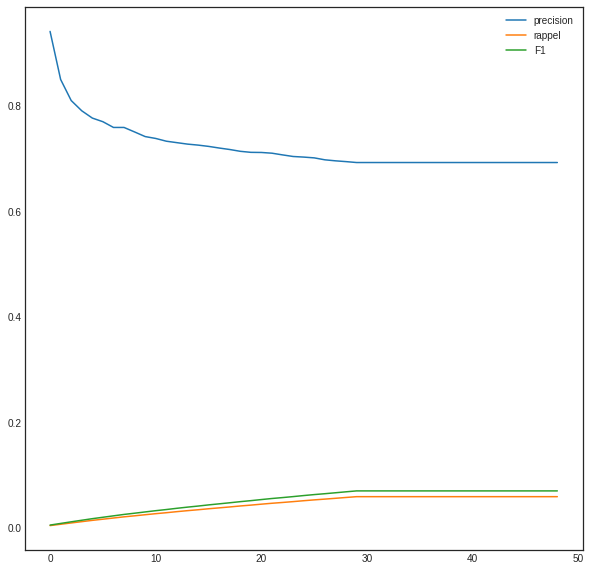

In [229]:
""" TFIDF """
ps = []
rs = []
fs = []

for i in range(1,50):
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(similaires, pertinents, k=i)

    ps.append(evaluations["precision"]["mean"])
    rs.append(evaluations["recall"]["mean"])
    fs.append(evaluations["F1"]["mean"])
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(ps, label="precision")
plt.plot(rs, label="rappel")
plt.plot(fs, label="F1")
plt.legend()
plt.show()

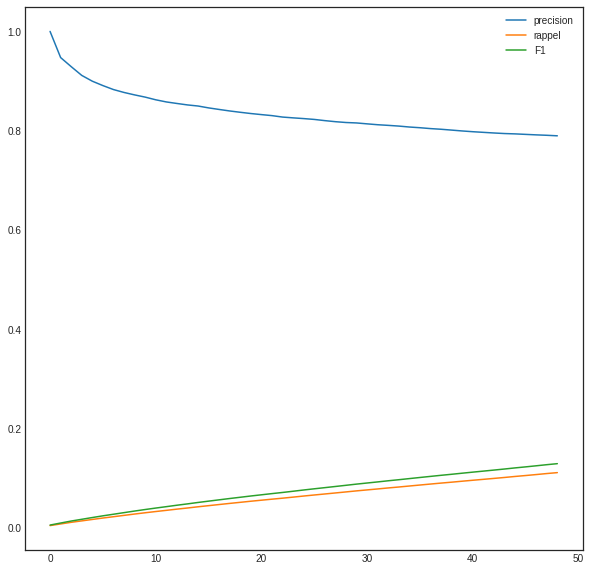

In [285]:
""" Embeddings"""
ps = []
rs = []
fs = []

for i in range(1,50):
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(similaires, pertinents, k=i)

    ps.append(evaluations["precision"]["mean"])
    rs.append(evaluations["recall"]["mean"])
    fs.append(evaluations["F1"]["mean"])
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(ps, label="precision")
plt.plot(rs, label="rappel")
plt.plot(fs, label="F1")
plt.legend()
plt.show()

Avec un modèle à base de bag of words:

In [22]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.350
rappel: 0.249
F1: 0.090


### comparons avec une autre méthode d'évaluation:

In [23]:
pertinent = []

for i, row in series_df.iterrows():
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += lol.split("-")
    regexp = "("+"|".join(genres)+")"
    pertinent.append(list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]))

In [24]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.592
rappel: 0.033
F1: 0.037


In [25]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=3, max_features=2000, stop_words=customstopwords)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []
for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.582
rappel: 0.033
F1: 0.036


# Approche Embeddings

# Similarités entre séries ( Word Embeddings )

#### - utilisation de word embeddings avec tf-idf pour trouver une mesure de similarité entre les différentes séries

## Principe

Dans ce qui suis nous utiliserons le terme "Document" pour dire "Série". Vu que l'on considère une série comme la concaténation de tous les sous titres de tous ses épisodes, et donc comme un long document.

Pour le calcul de similarité entre les documents, nous allons suivre la même méthode qu'avant :
- représenter un document par un vecteur
- utiliser des mesures de distance pour calculer la similarité entre deux vecteurs ( deux documents )

Ceci servira comme base pour faire un clustering de "genre" ou de "style" des documents.
Nous allons pour un début tester juste une combinaison de possibilités:
- démarrer à partir des vecteurs tf-idf des documents
- vecteurs word embedding généré par Word2vec
- distance de mesure : cosinus

### Word embedding ? 
Pour le définir rapidement, on peut dire que pour chaque mot du corpus on va avoir un vecteur de réels de taille fixe qui représentera d'une manière ou d'une autre le mot.

Et comme par magie des opérations vectoriels entre des mots ( vecteurs de réels ) nous donnes des mesures de similarités plutot correctes ! au lieu d'utiliser simplement tf-idf qui sont des vecteurs sparse.

Pour générer ces vecteurs nous allons utiliser Word2Vec entrainé sur le corpus entier, c'est à dire un gros fichier text qui contient l'ensemble des mots de tout le corpus.

### Document embedding ?
D'accord on a une représentation vectorielle de chaque mot qui marche comme par magie, mais nous souhaterions avoir une représentation similaire pour chaque document ( afin de mesurer cette similarité par magie aussi ).

Pour cela nous allons utiliser un simple principe:
- Soit V le vecteur représentant un Document lambda ( que ça soit tf-idf par exemple ) de taille N  (N = nombre de mots du vocabulaire ) 
- Soit la taille fixe du vecteur word embedding = p
- Soit la matrice M = N x p , càd N lignes ( N = nombre de mots du vocabulaire ) et p colonnes, ou chaque ligne i est le vecteur word embedding obtenu à partir de word2vec correspondant au ieme mot du vocabulaire
- Le vecteur D représentant le document embedding sera donc simplement :  D = V.M ( biensure on va s'arranger pour que la multiplication se passe bien en alignant les bonnes dimensions )

pour faire facile : le document sera la somme des word embeddings des mots qui le composent ( pondéré par tf-idf dans notre cas )


### Librarie personelle

Nous avons créer une classe qui permet de générer des matrices de similarités pour nos séries en suivant les étapes suivantes :
- Import de notre classe **CustomSim** du fichier **CustomSimilarity.py**
- Spécifier les différents paramètres de word2vec ( nombre de séries, taille du vecteur embedding, fenêtre de mots considérés .. )
- Spécifier un Tokenizer ( Suppression de stop words uniquement, stemming, lemmatizing .. )
- Spécifier un Vectorizer ( Bag of words, Tf-idf .. )
- Spécifier un Combiner, c'est à dire la manière de combiner les informations que l'on a pour obtenir un embedding d'une série
- Spécifier la mesure de similarité ( Cosine .. )

La classe est optimisée de tel sorte à que l'on puisse éviter de refaire des calculs déja fait, tous les calculs intermédiaires sont stockés dans des fichiers.

## Dans notre cas

Nous avons utilisé :
- Suppression de stop words seulement
- Tf-idf
- Somme des embeddings des mots d'une série pondérés par leurs tf-idf
- Mesure de similarité Cosinus

In [27]:
# A régler ultérieurement car ce n'est pas les memes noms de série entre Issam et Ismael
path = "/root/Documents/PLDAC/data"

### Redéfinition de quelques fonctions pour la compatibilité de la matrice

Nous n'avions pas les memes noms pour les séries donc il va falloir redéfinir quelques fonctions pour que le code marche

In [43]:
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    index = 0
    ch = ("".join(serie.split("_")[1:])).lower()
    for j, name in enumerate(series):
        if ch in ("".join(name.split("_"))).lower():
            index = j
            break
    mdr = [(series[i], a) for i, a in enumerate(sim[index])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k+1]][1:]:
        print("  ", " ".join(b))

In [25]:
""" Nous avons calculé les similarités pour 3000 séries en utilisant notre classe """
nbSeries = 3000
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]
len(series)

3000

#### Ouverture de la matrice calculé préalablement

In [26]:
sim = np.load("similarity_matrices/sim_13_.npy")

#printMatrice(sim, series)

In [56]:
krecommendations(sim, series, '2956_Criminal_Minds', 7)
krecommendations(sim, series, '2567_House', 7)
krecommendations(sim, series, '2469_The_Simpsons', 7)
krecommendations(sim, series, '381_Star_Trek__The_Next_Generation', 7)
krecommendations(sim, series, '196_Smallville', 7)

series les plus proches de Criminal Minds:
   Criminal Minds
   Criminal Minds  Suspect Behavior
   Profiler
   Millennium
   Cracked
   Perception
   Castle
series les plus proches de House:
   House
   Black Box
   Monday Mornings
   3 Lbs.
   Medical Investigation
   Emily Owens M.D.
   Grey s Anatomy
series les plus proches de The Simpsons:
   The Simpsons
   American Dad
   The Cleveland Show
   The Looney Tunes Show (2011)
   Man Up
   Raising Hope
   The Suite Life of Zack Cody
series les plus proches de Star Trek  The Next Generation:
   Star Trek  The Next Generation
   Star Trek  Enterprise
   Star Trek
   Star Trek  Voyager
   Star Trek Continues
   Star Trek  The Animated Series
   Blake s 7
series les plus proches de Smallville:
   Smallville
   Lois Clark  The New Adventures of Superman
   Heroes
   The 4400
   Terminator  The Sarah Connor Chronicles
   The Tomorrow People (US)
   Taken


Nous remarquons que les séries les plus similaires ont l'air d'être très très proches intuitivement

### Considérons les séries avec notes

In [57]:
series_df = pd.read_csv("series.csv")
series_df = series_df.dropna(subset=["genres"])
"""
J'AI CONTINUÉ À UTILISER LA VARIABLE SERIES, DONC ON L'ECRASE PAS
"""
#series = list(series_df["seriesname"])
series_df[["seriesname", "genres"]].head(3)

,seriesname,genres
0,2318_Raising_the_Bar,Drama
1,1159_Rejseholdet_(Unit_One),Drama
2,1821_Til_Death,Comedy


In [58]:
"""
Les résultats ne sont pas les mêmes car ici on prend en compte que la série doit être présente dans les
séries qui ont été notés
"""

serie = '_House'
index = None
ch = ("".join(serie.split("_")[1:])).lower()
for j, name in enumerate(series):
    x = ("".join(name.split("_")[1:])).lower()
    if ch == x:
        index = j
        break
p = index
mdr = sorted([(series[i], a) for i, a in enumerate(sim[p])], key=lambda x: x[1], reverse=True)

series_genres = list(series_df["seriesname"])

for a, e in mdr[:25]:
    realName = None
    ch = "".join(a.split("_")[1:])
    for j, name in enumerate(series_df["seriesname"]):
        x = "".join(name.split("_")[1:])
        if ch in x:
            realName = name
            break
    if realName is None:
        continue
    print("  ", " ".join(a.split("_")[1:]), "\t\t\t\t ", list(series_df[series_df["seriesname"]==realName]["genres"])[0])

Construisons la liste des séries pértinentes pour chaque série

In [59]:
import warnings
warnings.filterwarnings(action='once')

pertinent = []

for i, row in series_df.iterrows():
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += row["genres"].split("-")
    for i in range(len(genres) - 1):
        regexp += "("+"|".join(genres)+"){1}.*-"
    regexp += "("+"|".join(genres)+"){1}.*"
    pertinent.append(list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]))

A partir de la matrice de similarités, nous calculons quels sont les séries qui sont les plus similaires à la série choisie

In [60]:
similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([("".join(a.split("_")[1:])).lower() for a, b in mdr])

len(similaires)

3000

On supprime les séries non trouvables parmis celles notés

In [65]:
cleaned = False
if not cleaned:
    for k, index in enumerate(introuvables):
        similaires.pop(index-k)
cleaned = True

IndexError: pop index out of range

In [67]:
print(len(similaires),len(pertinent))

918 939


In [45]:
pertinent[1]

['thecritic',
 'phineasandferb',
 'dragonsridersofberk',
 'brickleberry',
 'monstersvs.aliens',
 'pennzeropart-timehero',
 'scooby-doomysteryincorporated',
 'bojackhorseman',
 'therickygervaisshow',
 'futurama',
 'theclevelandshow',
 'theawesomes',
 'metalocalypse',
 'thepowerpuffgirls',
 'theventurebros.',
 'rabbidsinvasion',
 'superjail',
 'adventuretimewithfinnandjake',
 'axecop',
 'daria',
 'regularshow',
 'trippingtherift',
 'thelifetimesoftim',
 'stevenuniverse',
 'robotchicken',
 'gravityfalls',
 'americandad',
 'lupinthe3rd',
 'thelooneytunesshow(2011)',
 'rickandmorty',
 'aquateenhungerforce',
 'theflintstones',
 'duckdodgers',
 'darkwingduck',
 'thesimpsons',
 'southpark',
 'bravestwarriors',
 'wanderoveryonder',
 'kingofthehill',
 'dilbert',
 'duckman',
 'xavierrenegadeangel',
 'uglyamericans',
 'pinkyandthebrain',
 'theboondocks',
 'thetick(1994)',
 'squidbillies',
 'bobsburgers',
 'danvs.',
 'blackdynamite']

In [ ]:
precision: 0.592
rappel: 0.033
F1: 0.037

### Evaluation des résultats

In [41]:
evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.283
rappel: 0.252
F1: 0.089


Surprise ! Les performances du système sont considérablement meilleures que d'utiliser tout simplement Bag of words ou bien Tf-idf.

La combinaison entre word2vec et Tf-idf améliore donc notre modèle de similarités

###  Tests avec stemming, lemmatizing ... à venir